# IoT - MCDA

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

### Score Function Analysis

##### Exponential

In [4]:
def exp_score(x,optimal,deviation):
    return np.exp(-np.power((x-optimal),2)/(2*np.power(deviation,2)))

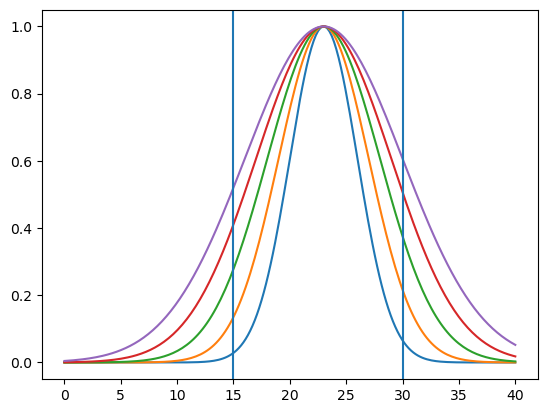

In [5]:
x_range = np.linspace(0,40,200)

for deviation in [3,4,5,6,7]:
    y_range = exp_score(x_range,23,deviation) # Temperature example

    plt.plot(x_range, y_range)
plt.axvline(x=30)
plt.axvline(x=15)

I feel like deviation = 5 is good. Maybe see for a skewed distribution

##### Linear

In [10]:
def linear_score(x,a,b,M):
    if a <= x <= b:
        return 1
    
    dev = np.abs(x-((a+b)/2)) 
    
    if dev > M:
        return 0
    
    return 1-dev/M

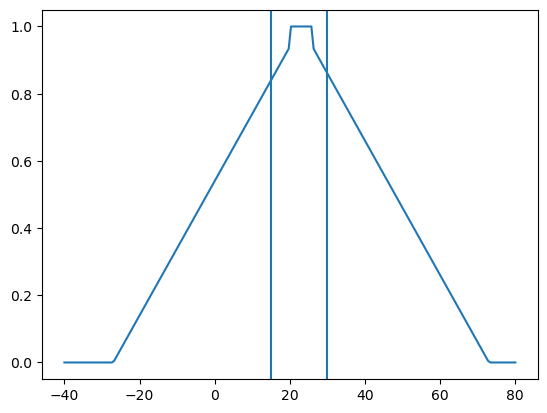

In [11]:
x_range = np.linspace(-40,80,200)
y_range = [linear_score(x,20,26,50) for x in x_range] # Temperature example

plt.plot(x_range, y_range)
plt.axvline(x=30)
plt.axvline(x=15)

This is really bad. Like no way 40 degree room should get any points

#### Temperature

In [12]:
def crazy_score(x,opt_small,opt_big,flexibility):
    if opt_small <= x <= opt_big:
        return 1
    if x < np.mean([opt_big,opt_small]):
        return np.exp(-np.power((x-20),2)/(2*np.power(flexibility,2)))
    if x > np.mean([opt_big,opt_small]):
        return np.exp(-np.power((x-26),2)/(2*np.power(flexibility-1,2)))
    

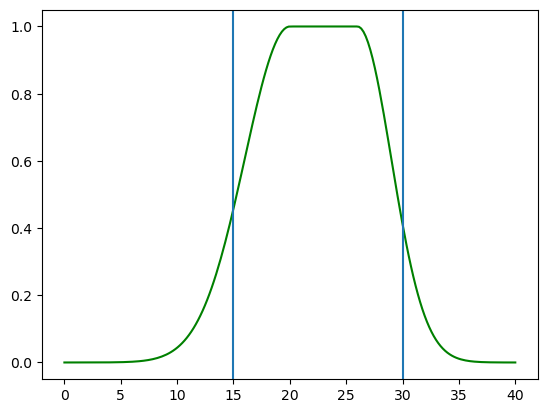

In [13]:
x_range = np.linspace(0,40,200)


y_range = [crazy_score(x,20,26,4) for x in x_range] # Temperature example

plt.plot(x_range, y_range, color='green')
plt.axvline(x=30)
plt.axvline(x=15)

### co2_score

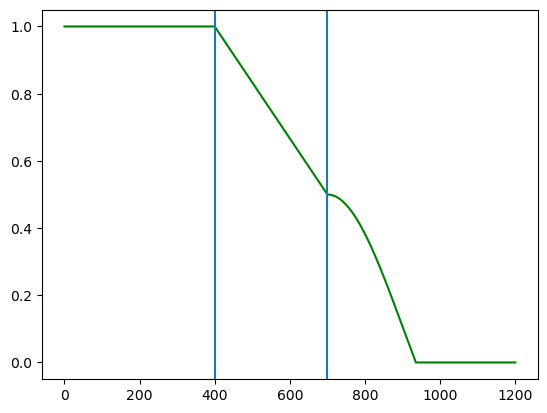

In [14]:
def crazy_score(x,opt_small,opt_big,flexibility):
    if x < opt_small:
        return 1
    if x < opt_big:
        return 1 - 0.5*((x-opt_small)/(opt_big-opt_small))
    else:
        return np.max([np.exp(-np.power((x-opt_big),2)/(2*np.power(flexibility,2)))-0.5,0])
    

x_range = np.linspace(0,1200,500)


y_range = [crazy_score(x,400,700,200) for x in x_range] # Temperature example

plt.plot(x_range, y_range, color='green')
plt.axvline(x=700)
plt.axvline(x=400)

### humidity score

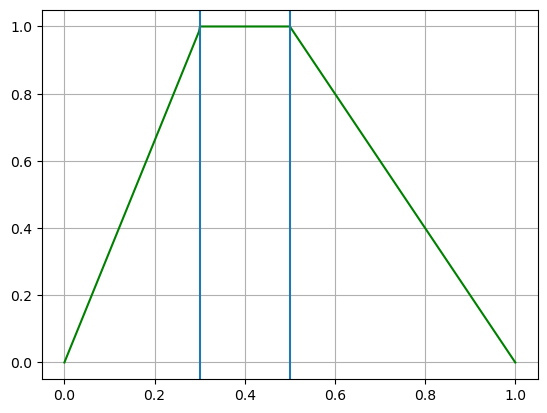

In [37]:
def crazy_score(x,opt_small,opt_big,flexibility):
    if x < opt_small:
        return 3.3*x
    if x < opt_big:
        return 1 
    return 1 - 0.4*((x-0.5)/(opt_big-opt_small))
    

x_range = np.linspace(0,1,500)


y_range = [crazy_score(x,0.3,0.5,200) for x in x_range] # Temperature example
plt.plot(x_range, y_range, color='green')
plt.axvline(x=0.3)
plt.axvline(x=0.5)
plt.grid()

### VOC score

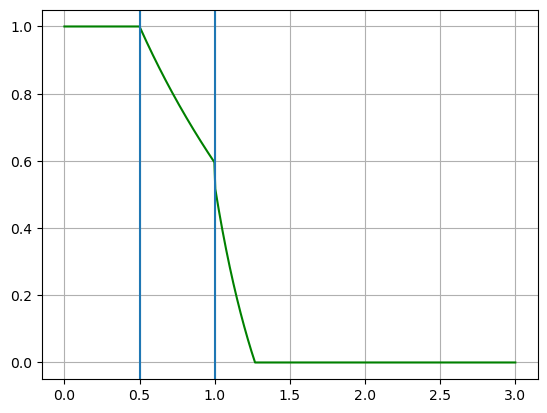

In [72]:
def crazy_score(x,opt_small,opt_big,flexibility):
    if x < opt_small:
        return 1
    if x < opt_big:
        return 1 - np.log(opt_small+x)
    return np.maximum(1/np.log(x+0.6)-1.6,0)
    

x_range = np.linspace(0,3,500)


y_range = [crazy_score(x,0.5,1,200) for x in x_range] # Temperature example
plt.plot(x_range, y_range, color='green')
plt.axvline(x=0.5)
plt.axvline(x=1)
plt.grid()

### Light score

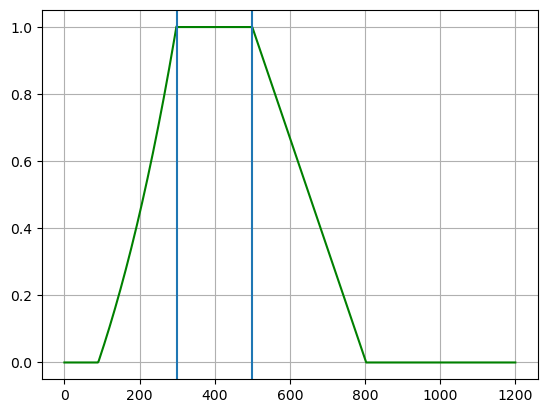

In [101]:
def crazy_score(x,opt_small,opt_big,flexibility):
    if x < opt_small:
        return np.maximum(np.exp(x/300 - 0.3)-1,0)
    if x < opt_big:
        return 1
    return np.maximum(1-0.0033*(x-500),0)
    

x_range = np.linspace(0,1200,500)


y_range = [crazy_score(x,300,500,200) for x in x_range] # Temperature example
plt.plot(x_range, y_range, color='green')
plt.axvline(x=300)
plt.axvline(x=500)
plt.grid()

### Sound score

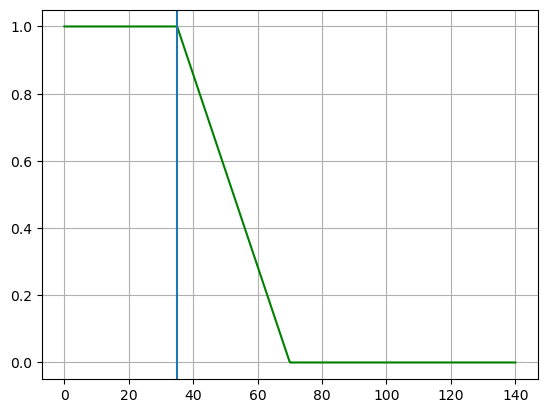

In [119]:
def crazy_score(x,opt_small,opt_big,flexibility):
    if x < opt_small:
        return 1
    return np.maximum(-(1/35)*x+2,0)
    

x_range = np.linspace(0,140,500)


y_range = [crazy_score(x,35,35,200) for x in x_range] # Temperature example
plt.plot(x_range, y_range, color='green')
plt.axvline(x=35)
plt.grid()

### Get priority from Consistency matrix

In [15]:
matrix = np.eye(3)
matrix[0,1] = 1/4
matrix[1,0] = 4
matrix[0,2] = 4
matrix[2,0] = 1/4
matrix[1,2] = 9
matrix[2,1] = 1/9

def extract_priorities(priority_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(priority_matrix)
    principal_eigenvector_idx = np.argmax(np.real(eigenvalues))
    principal_eigenvector = eigenvectors[:,principal_eigenvector_idx]
    principal_eigenvector /= np.sum(principal_eigenvector)
    return np.real(principal_eigenvector)

print(matrix)
print(extract_priorities(matrix))

[[1.         0.25       4.        ]
 [4.         1.         9.        ]
 [0.25       0.11111111 1.        ]]
[0.21716561 0.71706504 0.06576935]


In [48]:
import numpy as np
from typing import Union

class Abstract_AHP_Container:

    def __init__(self,base):
        '''
        base : array of dictionaries <string , float>
        '''
        self.size = len(base)
        self.depth = len(base[0].keys())
        self.container = np.zeros((self.depth,self.size,self.size))

    def comparison_matrix(self):
        raise NotImplementedError("Implement it in inheriting class")

    def extract_priorities(self):
        priority_vals = [0 for _ in range(self.depth)]
        for d in range(self.depth):
            eigenvalues, eigenvectors = np.linalg.eig(self.container[d])
            principal_eigenvector_idx = np.argmax(np.real(eigenvalues))
            principal_eigenvector = eigenvectors[:,principal_eigenvector_idx]
            principal_eigenvector /= np.sum(principal_eigenvector)
            priority_vals[d] = np.real(principal_eigenvector)
        return priority_vals
    
    
class Criterion:
    
    def __init__(self,criterion_name, perceived_importance : Union[float], sf = lambda x: x):
        self.name = criterion_name
        self.sf = sf
        self.priority = perceived_importance
        self.perceived_importance = perceived_importance
    
    def get_name(self):
        return self.name
    
    def get_score_func(self):
        return self.sf
    
    def get_priority(self):
        return self.priority
    
    def set_priority(self,p):
        self.priority = p

class Criteria(Abstract_AHP_Container):
        
    def __init__(self,criteria):
        list_of_criterions = [{"perceived_importance" : crit.perceived_importance} for crit in criteria]
        super().__init__(list_of_criterions)
        self.criteria = criteria
        self.comparison_matrix()
        self.normalise_priorities()
        self.priorities = {name: val for name, val in zip([crit.name for crit in self.criteria],np.array(self.extract_priorities()).flatten())}
        
        
    def comparison_matrix(self):
        for d in range(self.depth):
            for i in range(self.size):
                for j in range(i,self.size):
                    score1 = self.criteria[i].perceived_importance
                    score2 = self.criteria[j].perceived_importance
                    self.container[d,i,j] =  score1 / score2
                    self.container[d,j,i] =  score2 / score1
                    
    def normalise_priorities(self):
        priorities = [criterion.get_priority() for criterion in self.criteria]
        total = np.sum(priorities)
        for criterion in self.criteria:
            criterion.set_priority(criterion.get_priority()/total)
    
    def update_criterion_priorities(self):
        for idx,(k,v) in enumerate(self.priorities.items()):
            self.criteria[idx].priority = v
        

class Alternatives(Abstract_AHP_Container):
    
    def __init__(self,alternatives,criteria):
        '''
        alternatives : array of dictionaties <string,Float>
        criterions : array of criterions
        
        Constraint:
        criterions size has to match the size of the dictionary keys in alternative
        criterions names ordering have to match dictionary keys ordering
        '''
        super().__init__(alternatives)
        self.criteria = criteria
        self.alternatives = alternatives
        self.comparison_matrix()
        self.priorities = {k: array for k,array in zip(self.alternatives[0].keys(),self.extract_priorities())}
    
    
    def comparison_matrix(self):
        for d in range(self.depth):
            curr_criterion = self.criteria[d]
            score_f = curr_criterion.get_score_func()
            criterion_name = curr_criterion.get_name()
            for i in range(self.size):
                for j in range(i,self.size):
                    score1 = score_f(self.alternatives[i][criterion_name])
                    score2 = score_f(self.alternatives[j][criterion_name])
                    self.container[d,i,j] =  score1 / score2
                    self.container[d,j,i] =  score2 / score1
        
    
    def set_scoring_function(self,f):
        self.scoring_func = f
    
    def get_container(self):
        return self.container
    

class Goal:
    
    class Node:
        def __init__(self):
            self.name = "generic"
            pass
        
        def fetch_priorities(self):
            pass
       
    
    class Alternatives_Node(Node):
        
        def __init__(self, alternatives: 'Alternatives'):
            if not isinstance(alternatives,Alternatives):
                raise Exception("Unsuspected object has been passed")
            
            super().__init__()
            self.alternatives = alternatives
            self.name = "alternatives"
            self.connected_to=[]
        
        def fetch_priorities(self,name):
            return self.alternatives.priorities[name]
    
    
    class Criterion_Node(Node):
        
        def __init__(self, criterion: 'Criterion'):
            if not isinstance(criterion,Criterion):
                raise Exception("Unsuspected object has been passed")
            
            super().__init__()
            self.criterion = criterion
            self.name = self.criterion.name
            self.connected_to = []
            self.isFinalCriterion = False
        
        def add_connection(self, node:'Node'):
            if self.isFinalCriterion and isinstance(node,self.Criterion_Node):
                print("Cannot add Criterion to Final Criterion")
                return 
            
            if not self.connected_to and node.name == "alternatives":
                self.isFinalCriterion = True
            elif not self.isFinalCriterion and node.name == "alternatives":
                print("Cannot add Alternative to Intermediate Criterion")
                return 
            
            self.connected_to.append(node)
        
        def fetch_priorities(self):
            if self.isFinalCriterion:
                total_score = self.connected_to[0].fetch_priorities(self.name)
            else:
                total_score = np.sum([node.fetch_priorities() for node in self.connected_to], axis=0)
            
            return self.criterion.priority * total_score
                
    class Goal_Node(Node):
        
        def __init__(self):
            super().__init__()
            self.connected_to = []
            self.name = "head"
        
        def add_connection(self, node:'Criterion_Node'):
            self.connected_to.append(node)
        
        def fetch_priorities(self):
            total_score = np.sum([node.fetch_priorities() for node in self.connected_to], axis = 0)
            return total_score
                    
    
    def __init__(self,goal_name,alternatives=None):
        self.name = goal_name
        self.alternatives = alternatives 
        if self.alternatives:
            self.tail = self.Alternatives_Node(alternatives)
        self.head = self.Goal_Node()
        self.groups = []
    
    def dfs(self,start_node:'Node',search_name: 'str'):
        if start_node.name == search_name:
            return start_node
        
        possible = None
        for node in start_node.connected_to:
            possible = self.dfs(node,search_name)
            if possible.name == search_name:
                return possible
        return None
    
    def set_alternatives(self,alternatives):
        self.alternatives = alternatives
        self.tail = self.Alternatives_Node(alternatives)
    
    def add_criterion(self, obj: Union['Criterion','Alternatives'], init_node_name : str = "head"):
        init_node = self.dfs(self.head, init_node_name)
        
        if isinstance(obj,Criterion):
            end_node = self.Criterion_Node(obj)
        else:
            end_node = self.Alternatives_Node(obj)
        
        init_node.add_connection(end_node)
        
    def clear_criteria(self):
        self.head.connected_to = []
        
    def add_alt_to_leafs(self):
        self.add_alt_to_leafs_util(self.head)    
    
    def add_alt_to_leafs_util(self,start_node):
        if not start_node.connected_to:
            start_node.add_connection(self.tail)
            return
        for node in start_node.connected_to:
            self.add_alt_to_leafs_util(node)
    
    
    def compute_criterion_priorities(self):
        self.compute_criterion_priorities_util(self.head)
    
    def compute_criterion_priorities_util(self, start_node):

        list_of_criterions = [crit.criterion for crit in start_node.connected_to]
        c = Criteria(list_of_criterions)
        c.normalise_priorities()
        c.update_criterion_priorities()
        for node in start_node.connected_to:
            if not node.isFinalCriterion:
                self.compute_criterion_priorities_util(node)
    
    def make_decision(self):
        return self.head.fetch_priorities()
    
    def printTree(self):
        self.printTree_util(self.head, level=0)

    def printTree_util(self, start_node, level):
        '''
        Thank you gpt
        '''
        # Indent based on the current level to show hierarchy
        print(" " * (level * 4) + f"|-- {start_node.name}")
        for node in start_node.connected_to:
            self.printTree_util(node, level + 1)


    
    



In [49]:
rooms = [{"temperature": i, "humidity": 2*i+2, "Co2": 3+2*i+i**2} for i in [1,4,9]]
c1 = Criterion("temperature",1, lambda x:x)
c2 = Criterion("humidity",1, lambda x:x)
c3 = Criterion("Co2",1, lambda x:x)
c4 = Criterion("RoomFeel",1, lambda x:x)
criterions = [c1,c2,c3]

alt = Alternatives(rooms,criterions)

print(alt.priorities)

g = Goal("Best Room",alt)
g.add_criterion(c4)
g.add_criterion(c1,"RoomFeel")
g.add_criterion(c2,"RoomFeel")
g.add_criterion(c3)
g.add_alt_to_leafs()
g.printTree()

g.clear_criteria()
g.printTree()

{'temperature': array([0.07142857, 0.28571429, 0.64285714]), 'humidity': array([0.11764706, 0.29411765, 0.58823529]), 'Co2': array([0.04444444, 0.2       , 0.75555556])}
|-- head
    |-- RoomFeel
        |-- temperature
            |-- alternatives
        |-- humidity
            |-- alternatives
    |-- Co2
        |-- alternatives
|-- head


In [50]:
rooms = [{"temperature": i, "humidity": 2*i+2, "Co2": 3+2*i+i**2} for i in [1,4,9]]
c1 = Criterion("temperature",0.5, lambda x:x)
c2 = Criterion("humidity",0.5, lambda x:x)
c3 = Criterion("Co2",0.5, lambda x:x)
c4 = Criterion("RoomFeel",0.5, lambda x:x)
criterions = [c1,c2,c3]

alt = Alternatives(rooms,criterions)


g = Goal("Best Room")
g.set_alternatives(alt)
g.add_criterion(c4)
g.add_criterion(c1,"RoomFeel")
g.add_criterion(c2,"RoomFeel")
g.add_criterion(c3)
g.add_alt_to_leafs()
g.printTree()

g.compute_criterion_priorities()

g.make_decision()

|-- head
    |-- RoomFeel
        |-- temperature
            |-- alternatives
        |-- humidity
            |-- alternatives
    |-- Co2
        |-- alternatives


array([0.06949113, 0.24495798, 0.68555089])